In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

abtem.config.set(
    {
        "precision": "float64",
        "device": "cpu",
    }
);

# Bloch-wave simulations

Bloch-wave simulations are implemented in *ab*TEM as an alternative to the multislice simulations, offering advantages under certain conditions. Bloch waves allow for simulations of structures with arbitrary crystal rotations and arbitrary unit cells, which are difficult to handle in multislice due to the requirement of orthogonal and periodic unit cells.
Bloch waves are efficient for crystals described by small unit cells, but the computational cost in time and memory grows approximately linearly with the volume the unit cell. Hence, they become prohibitively expensive for large unit cells.

In this tutorial, we go through how to perform Bloch-wave simulations as implemented in *ab*TEM, and compare the simulation results to multislice.

:::{admonition} {material-regular}`engineering;1.5rem;sd-mr-1` Currently under construction
:class: no-icon
This section uses a new relatively untested feature.
:::

## Atomic model

We define an atomic structure using ASE. If you are used to simulating multislice, the main difference is that we should only define a single unit cell. The computational cost in time and memory grows approximately linearly with the volume the unit cell. Here, we a conventional unit cell of silicon. 

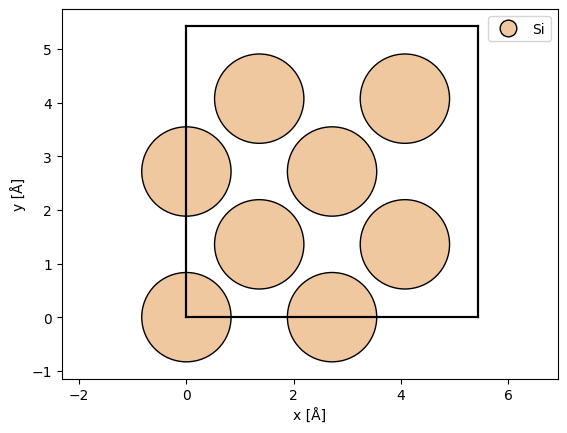

In [2]:
atoms = ase.build.bulk("Si", cubic=True)

abtem.show_atoms(atoms, legend=True);

## The structure factor

The structure factor is calculated using the independent atom model, as a superposition of atomic scattering factors:
$$
F(\mathbf{g}) = \sum_{j} f_j(g) \exp(-2\pi i \mathbf{g} \cdot \mathbf{r}_j)
$$
where $f_j(g)$ is the atomic scattering factor of the $j$'th atom. The Bloch-wave code uses the same parametrizations of the scattering factors as multislice, see our description in our [walkthrough on potentials](walkthrough:potentials). 

Here, we create a `StructureFactor` object representing the structure factor. We provide the two required keyword arguments: `atoms` we created above, and the maximum spatial frequency `g_max` given in $\mathrm{Å}^{-1}$ defines the maximum spatial frequency of the structure factor. Increasing `g_max` is equivalent to making the sampling (pixel size) smaller in a multislice simulation. As we describe later on, the $k$-vector of the simulated diffraction patterns, is half that of the structure factor.

We also provide the crystal centering, this will allow eliminating #TODO

When set to "auto" *ab*TEM will attempt to determine the lattice centering, but default to primitive, when that fails. 

In [3]:
g_max = 12.0

structure_factor = abtem.StructureFactor(
    atoms, g_max=g_max, parametrization="lobato", centering="F"
)

As other object in *ab*TEM, we can build the `StructureFactor` to get an array representation.

In [4]:
structure_factor_array = structure_factor.build().compute()

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

The structure factor is represented as a 1D array with an item for each reciprocal space vector. The reciprocal space vectors may be retrieved as a sequence of Miller indices (`.hkl`) or as reciprocal vectors (`.g_vec`) in units of $1/\mathrm{Å}$.  

In [5]:
print(structure_factor_array.array.shape)

(289437,)


A dictionary mapping from a tuple of miller indices, ($hkl$), to the complex structure factor $F_{hkl}$ can be obtained using the `.to_dict` method.

In [6]:
structure_factor_dict = structure_factor_array.to_dict()

structure_factor_dict[(0, 0, 0)]

np.complex128(0.2916122618483982+0j)

We can get the potential from the structure factor using a 3D Fourier transform
$$
V(\mathbf{r}) = \frac{4 \pi \epsilon_0}{2 \pi a_0 e} \int F(g) \exp(2\pi i \mathbf{g}\cdot \mathbf{r}) \mathrm{d}\mathbf{r} \quad ,
$$
where $\epsilon_0$ is the vaccum permitivity, $a_0$ is the Bohr radius and $e$ is the electron charge. Note that we use the unit convention from ASE, as described [here](appendix:conventions).

You can get the full 3D potential as a NumPy array using the `.get_potential_3d` method. The projected potential as `PotentialArray` object, which may be used in a normal *ab*TEM multislice simulation, can be obtained using `get_projected_potential`. This is currently only implemented for orthogonal unit cells.

tasks:   0%|          | 0/3 [00:00<?, ?it/s]

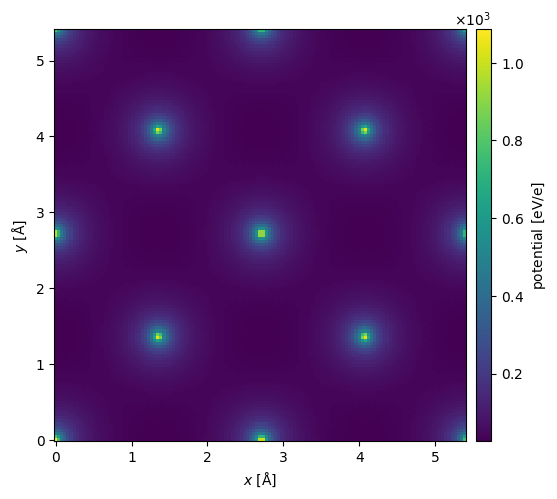

In [7]:
potential = structure_factor.get_projected_potential(slice_thickness=0.1)
potential.show(cbar=True)

We can approximate the inclusion of phonons by providing a `thermal_sigma`, which will apply a Debye-Waller factor to the structure factor, effectively, blurring the potential in real space
$$
F(\mathbf{g}) = \sum_{j} f_j(g) \exp(-2\pi i \mathbf{g} \cdot \mathbf{r}_j) \exp(-2 \pi^2 \sigma^2 g) .
$$


In, addition we can add an imaginary component to emulate absorption, with a typical but not generally very well justified value of 10\%:
$$
F_{absorption}(g) = F(g) + 0.1 i F(g).
$$

In [8]:
structure_factor_thermal = abtem.StructureFactor(
    atoms,
    g_max=g_max,
    parametrization="lobato",
    centering="F",
    thermal_sigma=0.078,
)

tasks:   0%|          | 0/3 [00:00<?, ?it/s]

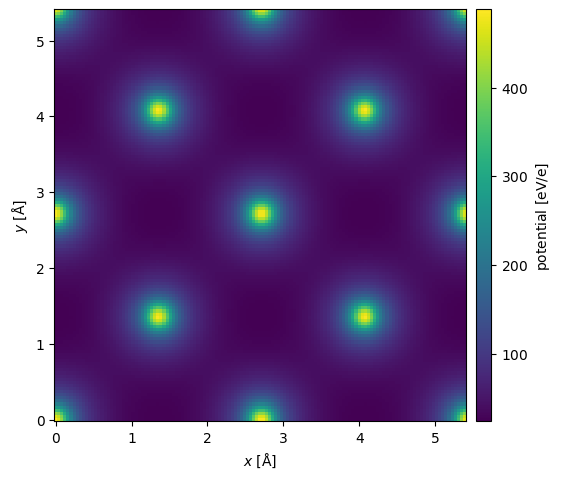

In [9]:
potential_phonons = structure_factor_thermal.get_projected_potential(slice_thickness=0.1)

potential_phonons.show(cbar=True)

## Bloch waves

We then go on to calculate the dynamical diffraction.

A Bloch wave is included in the simulation if, for a given incident direction, it is close enough to the Bragg condition. The deviation of the reflection from exact Bragg condition is measured by the excitation error $s_g$. *ab*TEM always assumes propagation from negative to postive $z$; thus for a given implied rotation of the reciprocal lattice vectors, the excitation error is calculated as
$$
s_g = -g_z - \frac{g^2}{2 k_0} \ ,
$$
where the Ewald sphere is approximated as a parabola.

For a given orientation, the $i$'th Bloch waves is included if
$$
|s_{g,i}| \leq s_{g,max} \ .
$$
You can control the maximum excitation error using the `sg_max` keyword. 

We may also select a $g_{max}$, which cannot exceed half that of the structure factor, in order to include all possible couplings between the Bloch waves.

In [10]:
sg_max = 0.2

bloch_waves = abtem.BlochWaves(
    structure_factor=structure_factor, energy=200e3, sg_max=sg_max, centering="F"
)

print(structure_factor.g_max, bloch_waves.g_max)

12.0 6.0


Once we have defined a structure factor, an energy and decided how many Bloch waves to include, our simulation is defined. 

The dropdown goes through how *ab*TEM calculates the structure matrix and the final simluation output.

The first step is calculating the structure matrix, $\mathbf{A}$, this is a square matrix with the same number of rows as the number of excited beams considered in the simulation. We define the diagonal elements as
$$
A_{ii} = \frac{2 k_0 s_g}{\sqrt{1 + g_{z,i} / k_0}}
$$
and the off-diagonal elements as 
$$
A_{ij} = \frac{U_{g_i - g_j}}{\sqrt{1 + g_{z,i} / k_0} \sqrt{1 + g_{z,j} / k_0}}
$$

$$
U_{g} = F_g
$$

The scattering matrix is given as
$$
\mathbf{S} = \mathbf{M} \exp\left(\frac{2\pi i t}{2 k_0} \mathbf{A}\right) \mathbf{M}^{-1}
$$
where $\mathbf{M}$ is a diagonal matrix with
$$
M_{ii} = \frac{1}{\sqrt{1+ g_z / k_0}} \ .
$$

We can get the structure matrix as follows.

In [11]:
structure_matrix = bloch_waves.calculate_structure_matrix()

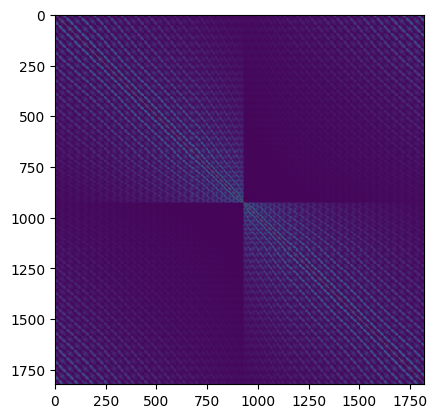

In [12]:
plt.figure()
plt.imshow(np.log(np.abs(1 + 1e3 * structure_matrix.compute())));

We can run our Bloch-wave simulation using the `calculate_diffraction_patterns` method, which takes the keyword `thicknesses` which can be a single thickness or a sequence of thicknesses. Here, we will get the results for each thickness of $5.43 \ \mathrm{Å}$ up to $645 \ \mathrm{Å}$.

If you come from a multislice background, one major difference is that large thicknesses are not more expensive than small thicknesses in a Bloch-wave simulation. (When the typical eigendecomposition is used for calculating the scattering.)

In [13]:
bloch_waves.hkl

array([[ 0,  0,  0],
       [ 0,  2,  0],
       [ 0,  4,  0],
       ...,
       [-1, -3, -1],
       [-1, -1,  1],
       [-1, -1, -1]], shape=(1821, 3))

In [14]:
thicknesses = np.arange(5.43, 645, 5.43)

diffraction_thickness_series = bloch_waves.calculate_diffraction_patterns(thicknesses)

diffraction_thickness_series.compute()

tasks:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
diffraction_thickness_series.shape

(118, 1821)

The output can be plotted for every 29th thickness (ie. every $158 \ \mathrm{Å}$).

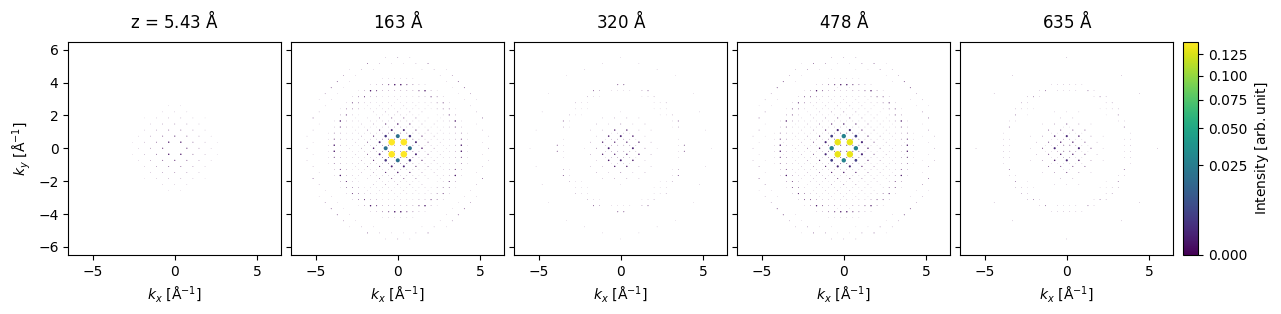

In [16]:
diffraction_thickness_series[::29].block_direct().show(
    explode=True,
    scale=.2,
    power=0.5,
    annotations=False,
    figsize=(14, 5),
    common_color_scale=True,
    cbar=True,
)

### Exporting results
You can export the results to NumPy array by simply getting the array and the matching miller indices

In [17]:
diffraction_thickness_series.array
diffraction_thickness_series.miller_indices

array([[ 0,  0,  0],
       [ 0,  2,  0],
       [ 0,  4,  0],
       ...,
       [-1, -3, -1],
       [-1, -1,  1],
       [-1, -1, -1]], shape=(1821, 3))

*ab*TEM supports conversion to several other formats, a good choice here might be an Xarray `DataArray`.

In [18]:
data_array = diffraction_thickness_series.to_data_array()
data_array

<xarray.DataArray (z: 118, hkl: 1821)> Size: 2MB
array([[9.97397596e-01, 1.72727382e-32, 1.14500432e-04, ...,
        3.55769272e-08, 3.03498799e-08, 2.66860012e-09],
       [9.90381509e-01, 7.23522781e-32, 4.68946651e-04, ...,
        1.60062728e-07, 1.00521348e-07, 1.21364880e-08],
       [9.79390603e-01, 2.72467446e-31, 1.07472171e-03, ...,
        3.86241899e-07, 2.01785047e-07, 2.93774299e-08],
       ...,
       [9.82080387e-01, 5.63801963e-27, 1.86839195e-03, ...,
        2.27828672e-06, 3.67562955e-05, 4.16252281e-07],
       [9.88746689e-01, 5.41665018e-27, 1.51024794e-03, ...,
        1.73225913e-06, 3.78267688e-05, 5.30004765e-07],
       [9.91603373e-01, 5.17561191e-27, 1.15464472e-03, ...,
        1.20719822e-06, 3.93324802e-05, 6.82705065e-07]],
      shape=(118, 1821))
Coordinates:
  * z        (z) float64 944B 5.43 10.86 16.29 21.72 ... 624.4 629.9 635.3 640.7
  * hkl      (hkl) <U10 73kB '0 0 0' '0 2 0' '0 4 0' ... '-1 -1 1' '-1 -1 -1'
    k        (hkl) float64 15kB 0.0 0.3683 0.7366 1.105 ... 0.6108 0.319 0.319
Attributes:
    long_name:  intensity
    units:      arb. unit

We can use `xarray` to slice the data, for example to show the intensity of of specific.

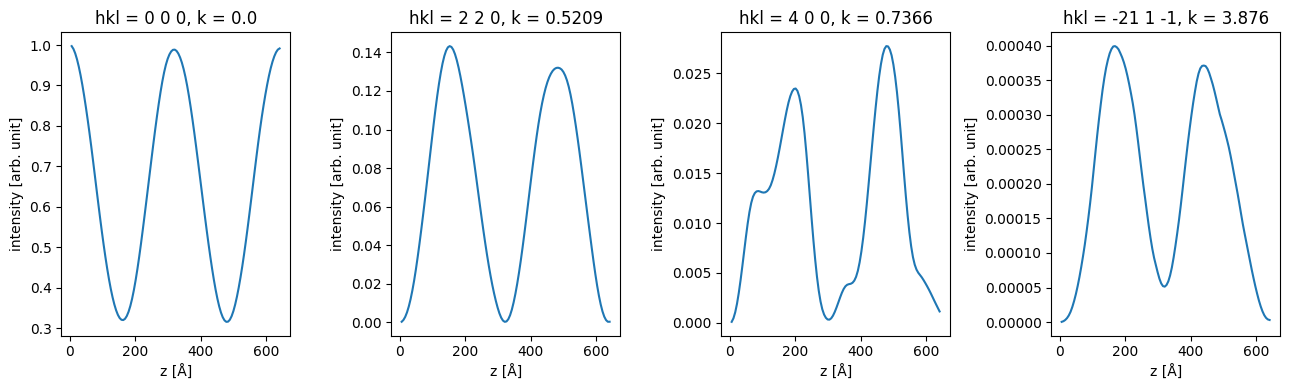

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(13, 4))

for ax, hkl in zip(axes, ["0 0 0", "2 2 0", "4 0 0", "-21 1 -1"]):
    data_array.sel(hkl=hkl).plot(hue="hkl", ax=ax)

plt.tight_layout()

## Rotations

We can get diffraction intensities from other directions using the `rotations` method. Here, we rotate about $z$ at $4$ different angles between $0$ and $45 \ \mathrm{deg}$, for each $z$ rotation we also rotate around $x$ at $5$ different angles between $0$ and $45 \ \mathrm{deg}$, i.e. resulting in $16$ different simulations. 

In [20]:
bloch_waves = abtem.BlochWaves(
    structure_factor=structure_factor, energy=200e3, sg_max=sg_max, centering="F"
)

x = np.linspace(0, np.pi / 4, 4)
z = np.linspace(0, np.pi / 4, 4)

ensemble = bloch_waves.rotate("z", z, "x", x)

The previous operation produces a `BlochwaveEnsemble` object, we run the same `calculate_diffraction_patterns` method to create the tasks for running a Bloch-wave simulation for each direction.

In [21]:
diffraction_patterns = ensemble.calculate_diffraction_patterns(thicknesses=1000)

diffraction_patterns.array

dask.array<getitem, shape=(4, 4, 11843), dtype=float64, chunksize=(1, 1, 11843), chunktype=numpy.ndarray>

In [22]:
diffraction_patterns.compute()

tasks:   0%|          | 0/49 [00:00<?, ?it/s]

()
()
()


In [23]:
diffraction_patterns.shape

(4, 4, 11843)

In [24]:
diffraction_patterns = diffraction_patterns.remove_low_intensity(1e-6)

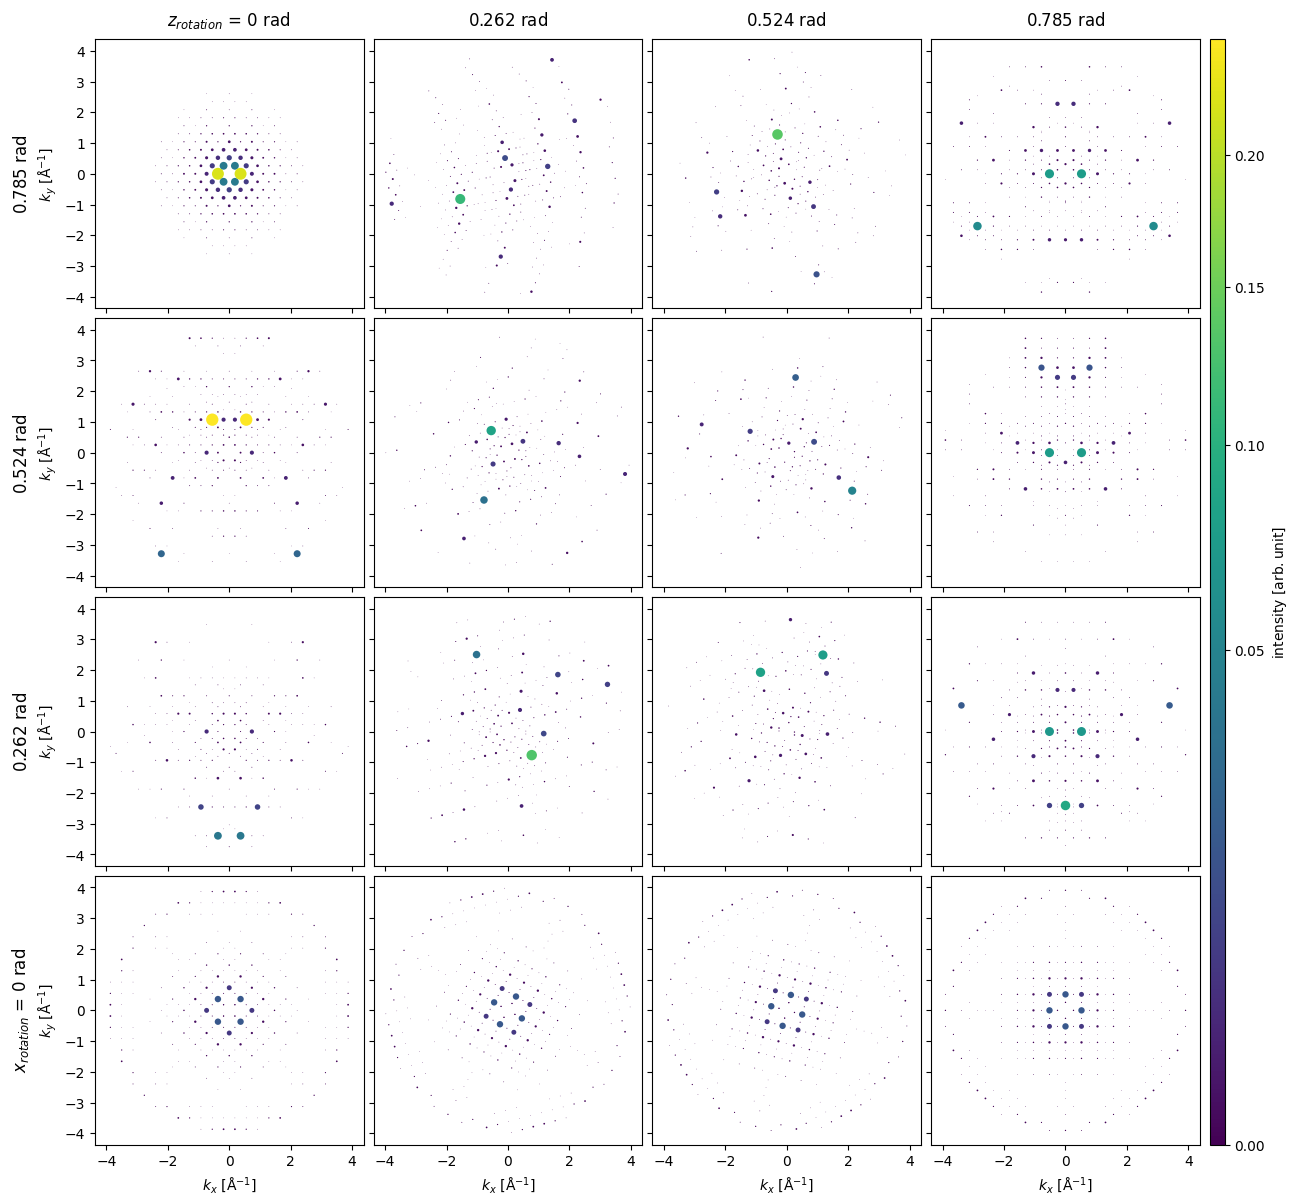

In [25]:
diffraction_patterns.crop(k_max=4).block_direct().show(
    explode=True,
    scale=0.2,
    power=0.5,
    annotation_kwargs={"threshold": 1},
    figsize=(14, 14),
    cbar=True,
    common_color_scale=True
)

Arbitrary rotations may be given as a sequence of [Euler angles](https://en.wikipedia.org/wiki/Euler_angles), for example, to rotate about a vector pointing along $(-1, 1, 0)$, we can rotate by $\pi/4$ around $z$, apply the desired rotations around $x$, and then rotate back by $-\pi/4$ around $z$.

In [26]:
z = np.tile([np.pi / 4], (4,))
x = np.linspace(0, np.pi / 2, 4)

rotations = np.array([z, x, -z]).T

In [27]:
ensemble = bloch_waves.rotate("zxz", rotations)

diffraction_patterns = ensemble.calculate_diffraction_patterns(1000).compute()

tasks:   0%|          | 0/17 [00:00<?, ?it/s]

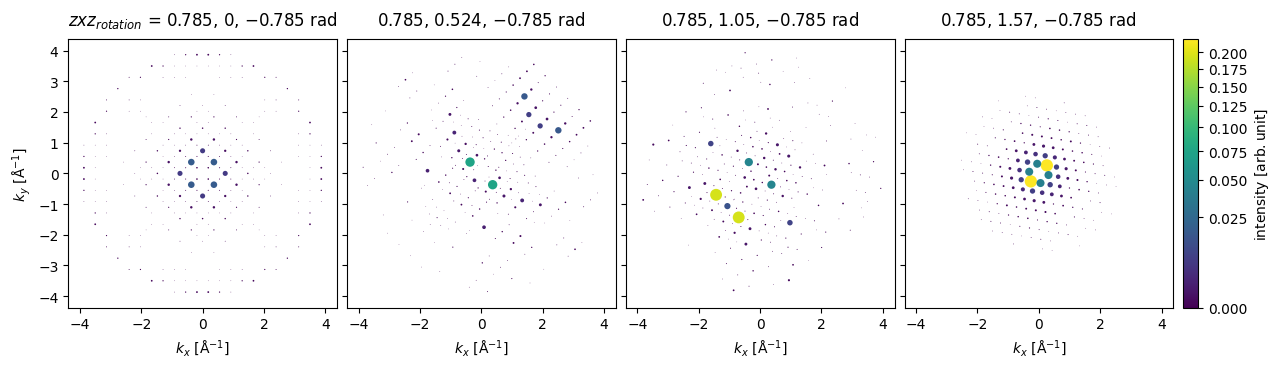

In [28]:
diffraction_patterns.crop(k_max=4).block_direct().show(
    explode=True,
    scale=0.2,
    power=0.5,
    annotation_kwargs={"threshold": 1},
    figsize=(14, 14),
    cbar=True,
    common_color_scale=True
)

## Comparison to multislice

In [29]:
g_max = 12

structure_factor = abtem.StructureFactor(
    atoms, g_max=g_max, parametrization="lobato", centering="F", thermal_sigma=0.078
)

In [30]:
potential_sf = structure_factor.get_projected_potential(slice_thickness=0.5)

potential_sf.sampling

(0.04082706766917293, 0.04082706766917293)

In [31]:
parametrization = abtem.parametrizations.LobatoParametrization(
    sigmas={"Si": 0.078}
)

potential = (
    abtem.Potential(
        atoms,
        sampling=potential_sf.sampling,
        slice_thickness=0.1,
        projection="finite",
        parametrization=parametrization,
    )
    .build()
    .compute(progress_bar=False)
)

tasks:   0%|          | 0/6 [00:00<?, ?it/s]

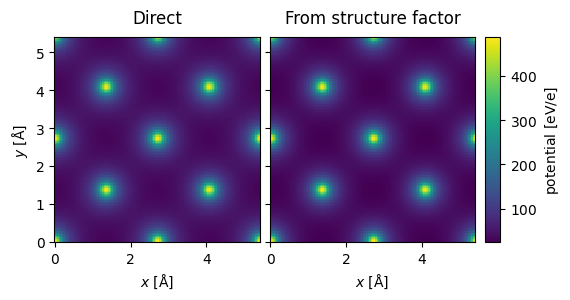

In [32]:
stack = abtem.stack(
    (potential.project(), potential_sf.project()), ("Direct", "From structure factor")
).compute()

stack.show(explode=True, common_color_scale=True, cbar=True);

In [33]:
pw = abtem.PlaneWave(energy=200e3)

nz = int(1086 / potential.thickness)

repeated_potential = abtem.CrystalPotential(
    potential, repetitions=[1, 1, nz], exit_planes=potential.num_slices
)

exit_waves_ms = pw.multislice(potential=repeated_potential).compute()

(201,)
()


tasks:   0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
bloch_waves = abtem.BlochWaves(
    structure_factor=structure_factor, energy=200e3, sg_max=sg_max
)

len(bloch_waves)

1821

In [35]:
exit_waves_bw = bloch_waves.calculate_exit_waves(
    repeated_potential.exit_thicknesses, gpts=exit_waves_ms.gpts
)

/Users/tomasusi/miniconda3/envs/abtem-py3.13/lib/python3.13/site-packages/abtem/bloch/dynamical.py:1636: PerformanceWarning: Increasing number of chunks by factor of 27
  array = da.blockwise(


In [36]:
exit_waves_bw.shape

(201, 133, 133)

In [37]:
exit_waves_ms.shape

(201, 133, 133)

In [38]:
stack = abtem.stack(
    [exit_waves_bw, exit_waves_ms],
    axis_metadata={"label": "algorithm", "values": ["MS", "BW"]},
    axis=1,
).compute()

tasks:   0%|          | 0/3738 [00:00<?, ?it/s]

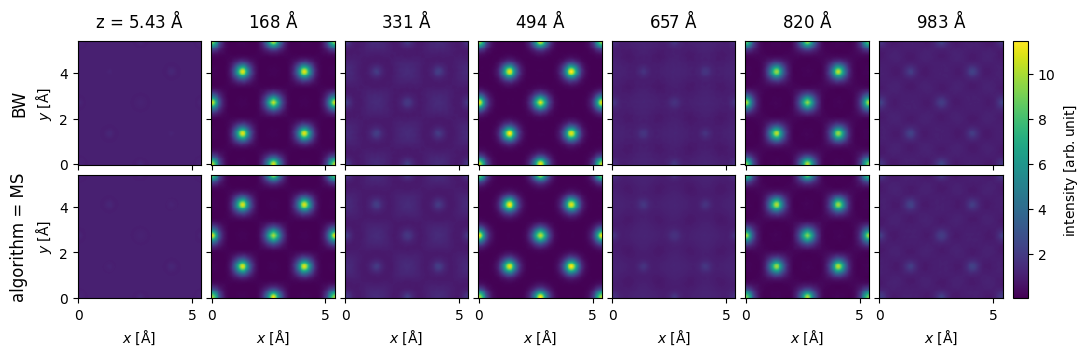

In [40]:
stack[1::30].show(explode=True, figsize=(12, 4), cbar=True, common_color_scale=True)

In [41]:
stacked_diffraction = (
    stack.diffraction_patterns().index_diffraction_spots(cell=atoms)
)

The difference below for the very weak [-21 1 -1] spot is mostly due to a slightly unconverged Bloch-wave calculation.

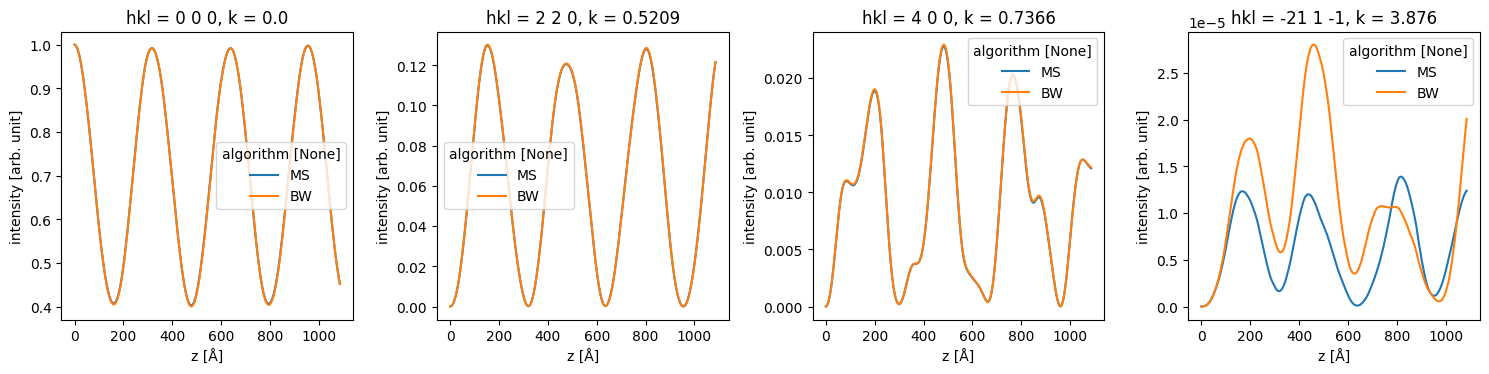

In [42]:
data_array = stacked_diffraction.to_data_array()

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for ax, hkl in zip(axes, ["0 0 0", "2 2 0", "4 0 0", "-21 1 -1"]):
    data_array.sel(hkl=hkl).plot(hue="algorithm", ax=ax)

plt.tight_layout()